# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [143]:
k1 = 8 / 10
k2 = 2 / 10
entropy = - (k1 * np.log(k1) + k2 * np.log(k2))
round(entropy, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
# Джини
H = k1 * (1 - k1) + k2 * (1 - k2)
n_Rl = 8
n_Rr = 2
# Критерий информативности 
Q = H - (n_Rl / 10) * 0 - (n_Rr / 10) * 0 #нулевая энтропия в каждой из подвершин
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [144]:
 np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [39]:
def compute_gini(array: np.array) -> float:
    unique, counts = np.unique(array, return_counts=True)
    probabilities = counts / np.sum(counts)
    return np.sum(probabilities * (1 - probabilities))

def compute_variance(array: np.array) -> float:
    return np.sum((array - np.mean(array)) ** 2) / len(array)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    thresholds = np.sort(np.unique(feature_vector))
    errors = []

    if feature_type == 'real':
        thresholds = (thresholds[1:] + thresholds[:-1]) / 2
        for threshold in thresholds:
            right = target_vector[feature_vector > threshold]
            left = target_vector[feature_vector <= threshold]
            if task == 'classification':
                error = compute_gini(target_vector) - (np.size(left) * compute_gini(left) + np.size(right) * compute_gini(right)) / len(target_vector)
            else:
                error = compute_variance(target_vector) - (np.size(left) * compute_variance(left) + np.size(right) * compute_variance(right)) / len(target_vector)
            errors.append(error)

    else:
        for threshold in thresholds:
            right = target_vector[feature_vector == threshold]
            left = target_vector[feature_vector != threshold]
            if task == 'classification':
                error = compute_gini(np.column_stack((feature_vector, target_vector))) - (np.size(left) * compute_gini(left) + np.size(right) * compute_gini(right)) / len(target_vector)
            else:
                error = compute_variance(np.column_stack((feature_vector, target_vector))) - (np.size(left) * compute_variance(left) + np.size(right) * compute_variance(right)) / len(target_vector)
            errors.append(error)

    return thresholds, np.array(errors), thresholds[np.argmax(errors)], np.max(errors)


Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [40]:
thresholds, variances, threshold_best, variance_best = find_best_split(X["MedInc"].to_numpy(), y, task="regression", feature_type="real")

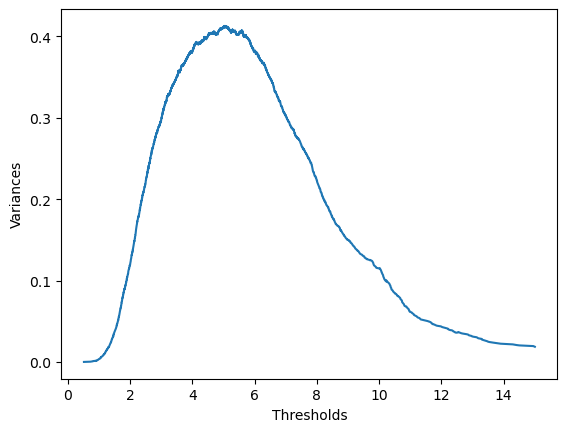

In [41]:
plt.plot(thresholds, variances)
plt.xlabel('Thresholds')
plt.ylabel('Variances')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [71]:
for i in X.columns:
    thresholds, variances, threshold_best, variance_best = find_best_split(X[i].to_numpy(), y, task="regression")
    print(f"{i}: treshold={threshold_best}; gini={variance_best}")

MedInc: treshold=5.03515; gini=0.41275138620167695
HouseAge: treshold=51.5; gini=0.030900940598321158
AveRooms: treshold=6.374305146225346; gini=0.15920795258922493
AveBedrms: treshold=1.1033776245480702; gini=0.015253415595943842
Population: treshold=1160.5; gini=0.0028306480479909357
AveOccup: treshold=3.1125433206272035; gini=0.07391870577793291
Latitude: treshold=37.935; gini=0.09033408765371975
Longitude: treshold=-121.86500000000001; gini=0.050211052033030334


Лучшим предикат - [MedInc>5.035150] (тк самая высокая хаотичность) 

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [46]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature_best] <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature_best] == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'nonterminal':
            if 'threshold' in node:
                if x[node['feature_split']] > node['threshold']:
                    return self._predict_node(x, node['right_child'])
                return self._predict_node(x, node['left_child'])
            else:
                if x[node['feature_split']] == node['category_split']:
                    return self._predict_node(x, node['left_child'])
                return self._predict_node(x, node['right_child'])  
        return node['class']

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [56]:
students = pd.read_csv('students.csv')
students.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [62]:
feautures = students.drop(['Unnamed: 0', 'UNS'], axis = 1)

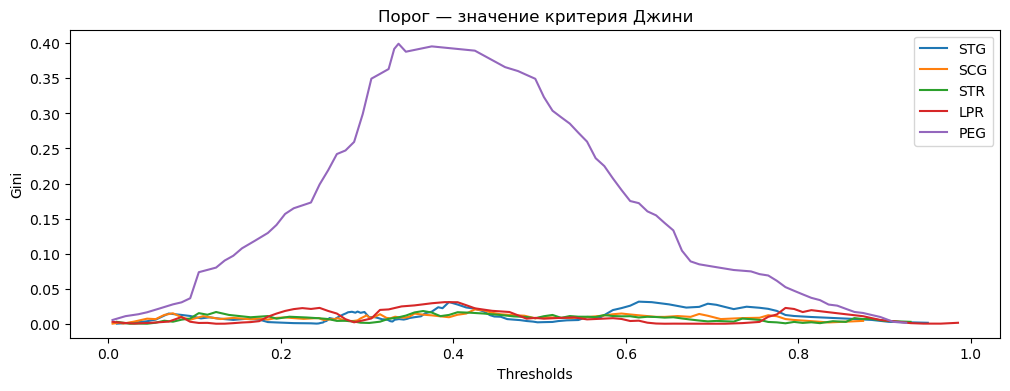

In [72]:
fig = plt.figure(figsize=(12, 4))
for i in range(len(feautures.columns)):
    thresholds, variances, threshold_best, variance_best = find_best_split(feautures.iloc[:, i].to_numpy(), students['UNS'], task="classification", feature_type="real")
    plt.plot(thresholds, variances, label = feautures.columns[i])
plt.title('Порог — значение критерия Джини')
plt.xlabel('Thresholds')
plt.ylabel('Gini')
plt.legend()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

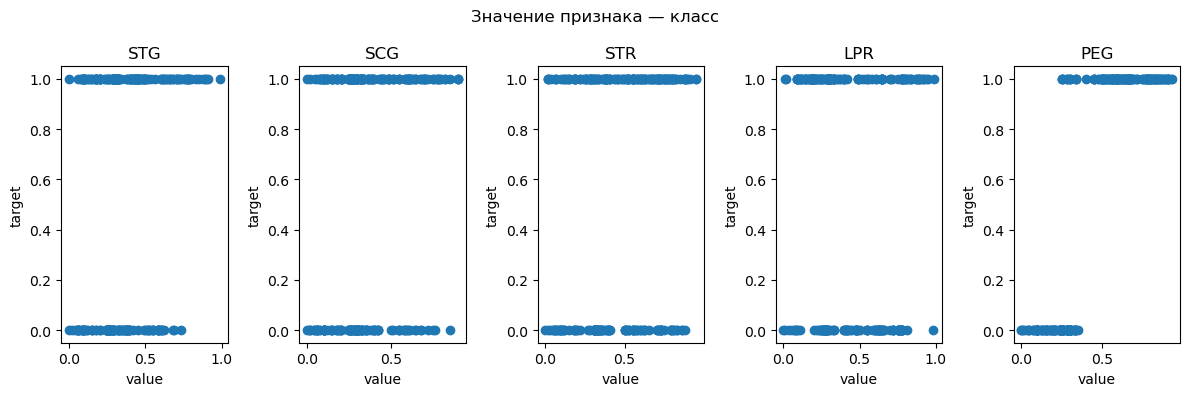

In [74]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4), layout='tight')
fig.suptitle('Значение признака — класс')

for i in range(len(feautures.columns)):
    ax[i].scatter(feautures[feautures.columns[i]], students['UNS'], label=i)
    ax[i].set_xlabel('value')
    ax[i].set_ylabel('target')
    ax[i].set_title(feautures.columns[i])

plt.show()

Исходя из критерия Джинни лучше делить по PEG, т.к. там наибольшее значение. Этот результат согласуется с построенными диаграммами, именно на PEG наиболее хорошо видны классы. Вид кривой для хороших признаков выглядит как функция выпуклая вверх функция, вид кривой для плохих признаков близок к прямой.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [75]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [76]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
mushrooms = mushrooms.apply(LabelEncoder().fit_transform)
mushrooms

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [82]:
from sklearn.model_selection import train_test_split
X = mushrooms.drop(['p'], axis = 1)
y = mushrooms['p']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [83]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_test = X_test.to_numpy()

In [86]:
from sklearn.metrics import accuracy_score

decisionTreeClassifier = DecisionTree(feature_types=['categorical'] * len(X_train))
decisionTreeClassifier.fit(X_train, y_train)
prediction = decisionTreeClassifier.predict(X_test)
accuracy_score(y_test, prediction)

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [87]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [88]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

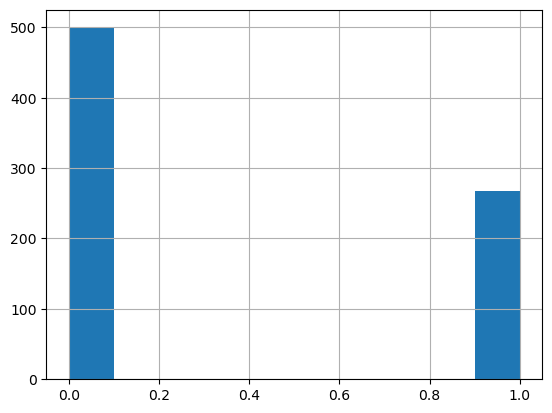

In [89]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [121]:
X = data.drop(['Outcome'], axis = 1)
y = data['Outcome']

In [122]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

max_depths = [3, 5, 7, 10]
min_samples_leafs = [5, 10, 15, 20, 25, 30]
depth = 0
leaf = 0
f1 = 0
for max_depth, min_samples_leaf in zip(max_depths, min_samples_leafs):
    tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    tree.fit(X_train, y_train)
    prediction = tree.predict(X_valid)
    if f1_score(y_valid, prediction) > f1:
        f1 = f1_score(y_valid, prediction)
        depth = max_depth
        leaf = min_samples_leaf
print(depth, leaf)

5 10


In [124]:
tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
tree.fit(X_train_valid, y_train_valid)
y_pred = tree.predict(X_test)

In [125]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print(f'accuracy {accuracy_score(y_test, y_pred)}')
print(f'precision {precision_score(y_test, y_pred)}')
print(f'recall {recall_score(y_test, y_pred)}')
print(f'auc-roc {roc_auc_score(y_test, y_pred)}')

accuracy 0.7532467532467533
precision 0.6666666666666666
recall 0.575
auc-roc 0.711341059602649


Модель неплохо разделяет классы, однако много положительных объектов не выявлены (recall невысокий). В модели, которая должна предсказывать болезни recall важнее precision, поэтому качество модели сомнительное.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [136]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(estimator=tree, n_estimators=50)
bc.fit(X_train_valid, y_train_valid)
y_pred = bc.predict(X_test)

In [137]:
print(f'accuracy {accuracy_score(y_test, y_pred)}')
print(f'precision {precision_score(y_test, y_pred)}')
print(f'recall {recall_score(y_test, y_pred)}')
print(f'auc-roc {roc_auc_score(y_test, y_pred)}')

accuracy 0.7705627705627706
precision 0.6588235294117647
recall 0.7
auc-roc 0.7539735099337749


Все показатели выросли, recall сильно вырос, поэтому модель хорошо определяет больных.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [128]:
from sklearn.model_selection import cross_val_score
max_depths = np.linspace(1, 20, num=20, dtype=int)
min_samples_splits = np.linspace(2, 25, num=24, dtype=int)
depth = 0
samples_split = 0
f1 = 0
for md, mss in zip(max_depths, min_samples_splits):
    rfc = RandomForestClassifier(n_estimators=50, max_depth=md, min_samples_leaf=mss, random_state=42)
    f1_score = cross_val_score(rfc, X_train_valid, y_train_valid, scoring='f1', error_score='raise')
    if np.mean(f1_score) >= f1:
        f1 = np.mean(f1_score)
        depth = md
        samples_split = mss
print(f1, depth, samples_split)

0.6180690232075629 6 7


In [129]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_leaf=samples_split)
rfc.fit(X_train_valid, y_train_valid)
y_pred = rfc.predict(X_test)

In [130]:
print(f'accuracy {accuracy_score(y_test, y_pred)}')
print(f'precision {precision_score(y_test, y_pred)}')
print(f'recall {recall_score(y_test, y_pred)}')
print(f'auc-roc {roc_auc_score(y_test, y_pred)}')

accuracy 0.7489177489177489
precision 0.6447368421052632
recall 0.6125
auc-roc 0.7168460264900662


Работает очень близко ко 2 модели. Из всех рассмотренных я бы выбрала 2 модель, т.к. она наболее точно распознает больных людей

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

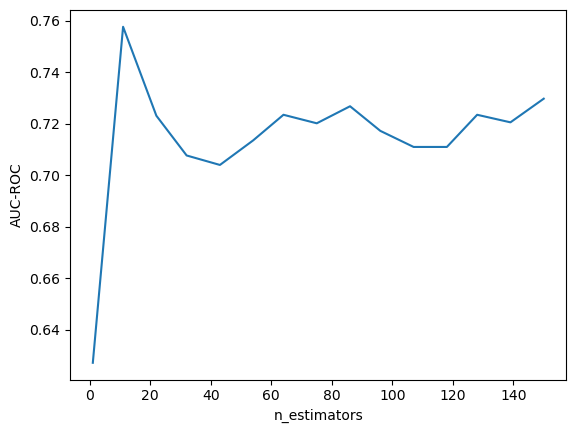

In [134]:
n = np.linspace(1, 150, num=15, dtype=int)
ar = []
for n_estimator in n:
    rfc = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_split=samples_split, random_state=42)
    rfc.fit(X_train_valid, y_train_valid)
    y_pred = rfc.predict(X_test)
    ar += [roc_auc_score(y_test, y_pred)]

plt.figure()
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.plot(n, ar)
plt.show()

До определенного порога качество модели резко улучается с увеличением количества деревьев, но при слишком большом количестве модель переобучается

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

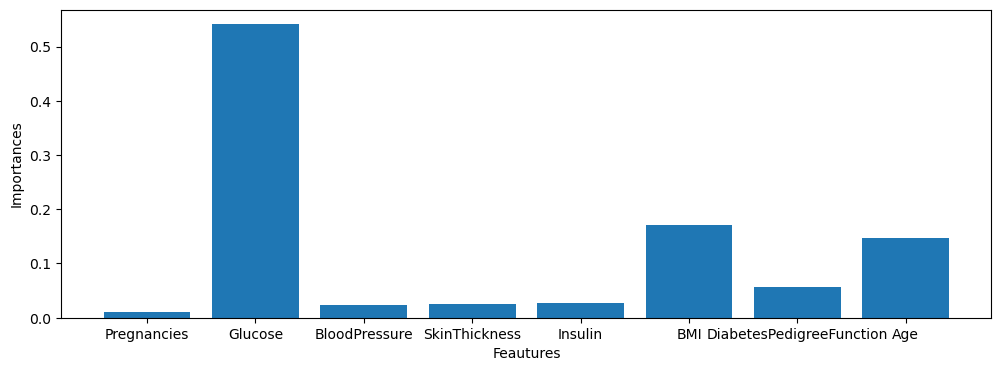

<Figure size 640x480 with 0 Axes>

In [142]:
feature_importances = np.mean([tree.feature_importances_ for tree in bc.estimators_], axis=0)
fig, ax = plt.subplots(figsize=(12, 4))
plt.bar(X_train.columns, feature_importances)
ax.set_ylabel("Importances")
ax.set_xlabel("Feautures")
plt.show()
plt.tight_layout()

Самый важный признак -уровень глюкозы